# Gene Selection 

Compare different gene selection methods and results

# Inputs

In [1]:
%env THEANO_FLAGS='base_compiledir=/mnt/research_serializations/Gene-Selection'
out_dir = '/mnt/research_serializations/Gene-Selection'

env: THEANO_FLAGS='base_compiledir=/mnt/research_serializations/Gene-Selection'


In [2]:
import rnaseq_lib3 as r
import pandas as pd
import scipy.stats as st
import pymc3 as pm
import numpy as np
import time
import os
from tqdm import tqdm_notebook as tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read in centered data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt.hd5')
# Subset
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal'].sort_values('tissue')
tumor = df[df.label == 'tcga-tumor'].sort_values('tissue')
# Read in drug genes
genes = df.columns[5:]
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

# Methods

In [4]:
tissue = 'Adrenal'
ran_sample = np.random.choice(tumor[tumor.tissue == tissue].index)
sample = tumor.loc[ran_sample]
sample = tumor.loc['TCGA-OR-A5KV-01']
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]
ranks.head()

,Group,MedianRank
0,Adrenal,63.0
1,Kidney,1184.0
2,Ovary,1268.5
3,Stomach,1787.0
4,Pituitary,1813.0


## f_classif

In [5]:
classif_genes = r.outlier.select_k_best_genes(training_group, genes, 'tissue', 50)
m0, t0 = r.outlier.run_model(sample, training_group, classif_genes)

Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [SIX6=Stomach, SIX6=Pituitary, SIX6=Ovary, SIX6=Kidney, SIX6=Adrenal, POU1F1=Stomach, POU1F1=Pituitary, POU1F1=Ovary, POU1F1=Kidney, POU1F1=Adrenal, GRTP1-AS1=Stomach, GRTP1-AS1=Pituitary, GRTP1-AS1=Ovary, GRTP1-AS1=Kidney, GRTP1-AS1=Adrenal, C1QTNF1-AS1=Stomach, C1QTNF1-AS1=Pituitary, C1QTNF1-AS1=Ovary, C1QTNF1-AS1=Kidney, C1QTNF1-AS1=Adrenal, AC009410.1=Stomach, AC009410.1=Pituitary, AC009410.1=Ovary, AC009410.1=Kidney, AC009410.1=Adrenal, LHX9=Stomach, LHX9=Pituitary, LHX9=Ovary, LHX9=Kidney, LHX9=Adrenal, TCF23=Stomach, TCF23=Pituitary, TCF23=Ovary, TCF23=Kidney, TCF23=Adrenal, RP11-116D17.3=Stomach, RP11-116D17.3=Pituitary, RP11-116D17.3=Ovary, RP11-116D17.3=Kidney, RP11-116D17.3=Adrenal, SIX3-AS1=Stomach, SIX3-AS1=Pituitary, SIX3-AS1=Ovary, SIX3-AS1=Kidney, SIX3-AS1=Adrenal, FAM155A=Stomach, FAM155A=Pituitary, FAM155A=Ovary, FAM155A=Kidney, FAM155A=Adrenal, GHRHR=Stomach, GHRHR=Pituitary, GHRHR=Ovary, GHRHR=Kidney, GHRHR=Adrenal, V

### Traceplot

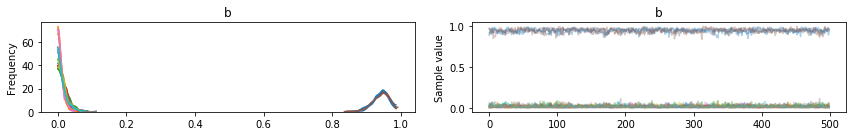

In [6]:
pm.traceplot(t0, varnames=['b']);

### Model Weights

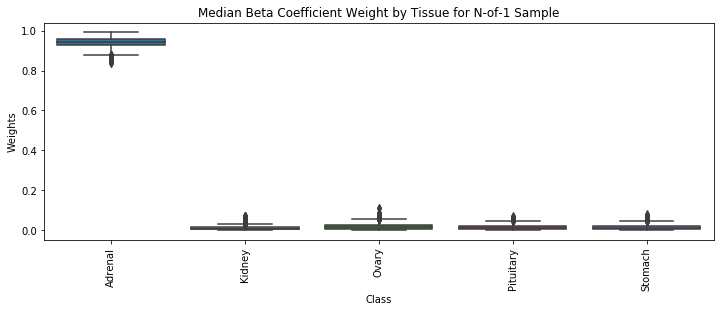

In [7]:
r.outlier.plot_weights(training_group.tissue.unique(), t0)

In [9]:
ppc0 = r.outlier.ppc(t0, classif_genes)
ppp0 = r.outlier.posterior_predictive_pvals(sample, ppc0)

## Chi2

In [10]:
chi2_genes = r.outlier.select_k_best_genes(training_group, genes, 'tissue', 50, 'chi2')
m1, t1 = r.outlier.run_model(sample, training_group, chi2_genes)

Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [SIX6=Stomach, SIX6=Pituitary, SIX6=Ovary, SIX6=Kidney, SIX6=Adrenal, POU1F1=Stomach, POU1F1=Pituitary, POU1F1=Ovary, POU1F1=Kidney, POU1F1=Adrenal, LHX3=Stomach, LHX3=Pituitary, LHX3=Ovary, LHX3=Kidney, LHX3=Adrenal, TSHB=Stomach, TSHB=Pituitary, TSHB=Ovary, TSHB=Kidney, TSHB=Adrenal, CH507-152C13.3=Stomach, CH507-152C13.3=Pituitary, CH507-152C13.3=Ovary, CH507-152C13.3=Kidney, CH507-152C13.3=Adrenal, GHRHR=Stomach, GHRHR=Pituitary, GHRHR=Ovary, GHRHR=Kidney, GHRHR=Adrenal, ATP4B=Stomach, ATP4B=Pituitary, ATP4B=Ovary, ATP4B=Kidney, ATP4B=Adrenal, SIX3=Stomach, SIX3=Pituitary, SIX3=Ovary, SIX3=Kidney, SIX3=Adrenal, SLC22A12=Stomach, SLC22A12=Pituitary, SLC22A12=Ovary, SLC22A12=Kidney, SLC22A12=Adrenal, SLC22A6=Stomach, SLC22A6=Pituitary, SLC22A6=Ovary, SLC22A6=Kidney, SLC22A6=Adrenal, GIF=Stomach, GIF=Pituitary, GIF=Ovary, GIF=Kidney, GIF=Adrenal, LHB=Stomach, LHB=Pituitary, LHB=Ovary, LHB=Kidney, LHB=Adrenal, HSD3B2=Stomach, HSD3B2=Pitu

### Traceplot

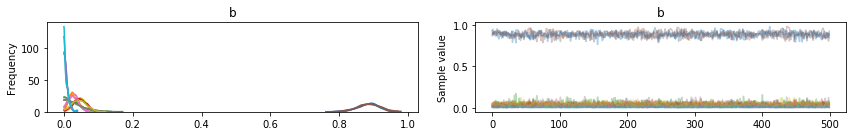

In [12]:
pm.traceplot(t1, varnames=['b']);

### Model Weights

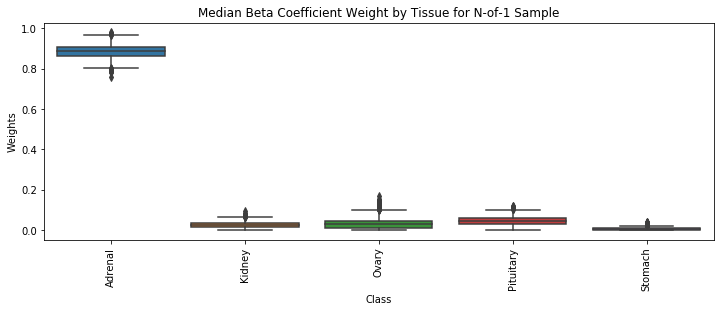

In [13]:
r.outlier.plot_weights(training_group.tissue.unique(), t1);

In [16]:
ppc1 = r.outlier.ppc(t1, chi2_genes)
ppp1 = r.outlier.posterior_predictive_pvals(sample, ppc1)

# Correlation

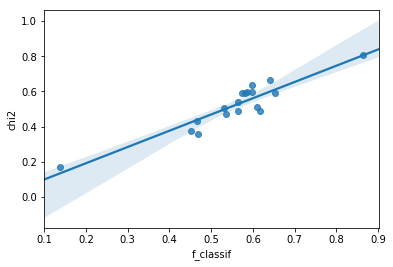

In [19]:
plot = pd.concat([ppp0, ppp1], axis=1).dropna()
plot.columns = ['f_classif', 'chi2']
sns.regplot(data=plot, x='f_classif', y='chi2');